# 1. Data Exploration

Explore the EEG data and visualize the signals to understand the characteristics of the dataset.

## Import statements

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import mne
import sys, os
from pathlib import Path
sys.path.append(os.path.abspath(".."))
from src.utils import markers, load_eeg, load_labels, get_event_epochs


## Import Data

In [4]:
DATA = Path("../data/raw")
subject = "S001"

In [5]:
# Label descriptions mapping
label_desc = {
    'SS': 'Sleep Spindles',  # 'SS' and 'S' may both be used in some label schemes
    'S': 'Sleep Spindles',
    'K': 'K-Complexes',
    'REM': 'Rapid Eye Movements',
    'Son': 'Sleep Onset',
    'Soff': 'Sleep Offset',
    'A': 'Arousals',
    'MS': 'Microsleep'
}

# Quick check: print the mapping and show keys present in labels (if the labels df exists)
print('label_desc:', label_desc)
if 'labels' in globals():
    print('Unique label values in labels df:', sorted(labels['Marker'].unique()))


label_desc: {'SS': 'Sleep Spindles', 'S': 'Sleep Spindles', 'K': 'K-Complexes', 'REM': 'Rapid Eye Movements', 'Son': 'Sleep Onset', 'Soff': 'Sleep Offset', 'A': 'Arousals', 'MS': 'Microsleep'}


In [6]:
eeg = load_eeg(DATA, subject)
labels = load_labels(DATA, subject)
labels.head()

Creating RawArray with float64 data, n_channels=1, n_times=5394412
    Range : 0 ... 5394411 =      0.000 ... 21577.644 secs
Ready.
    Range : 0 ... 5394411 =      0.000 ... 21577.644 secs
Ready.
<Info | 7 non-empty values
 bads: []
 ch_names: EEG1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>
<Info | 7 non-empty values
 bads: []
 ch_names: EEG1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>


,Marker,Timestamp_samples,Epoch
0,REM,38643,6
1,REM,39196,6
2,REM,39404,6
3,REM,40046,6
4,REM,40725,6


In [7]:
raw = eeg.get_data()

# create time vector
sfreq = eeg.info['sfreq']
n_times = eeg.n_times
times = np.arange(n_times) / sfreq
print(f"Sampling frequency: {sfreq} Hz")
print(f"Number of time points: {n_times}")
print(f"Duration: {n_times/sfreq} seconds")

Sampling frequency: 250.0 Hz
Number of time points: 5394412
Duration: 21577.648 seconds


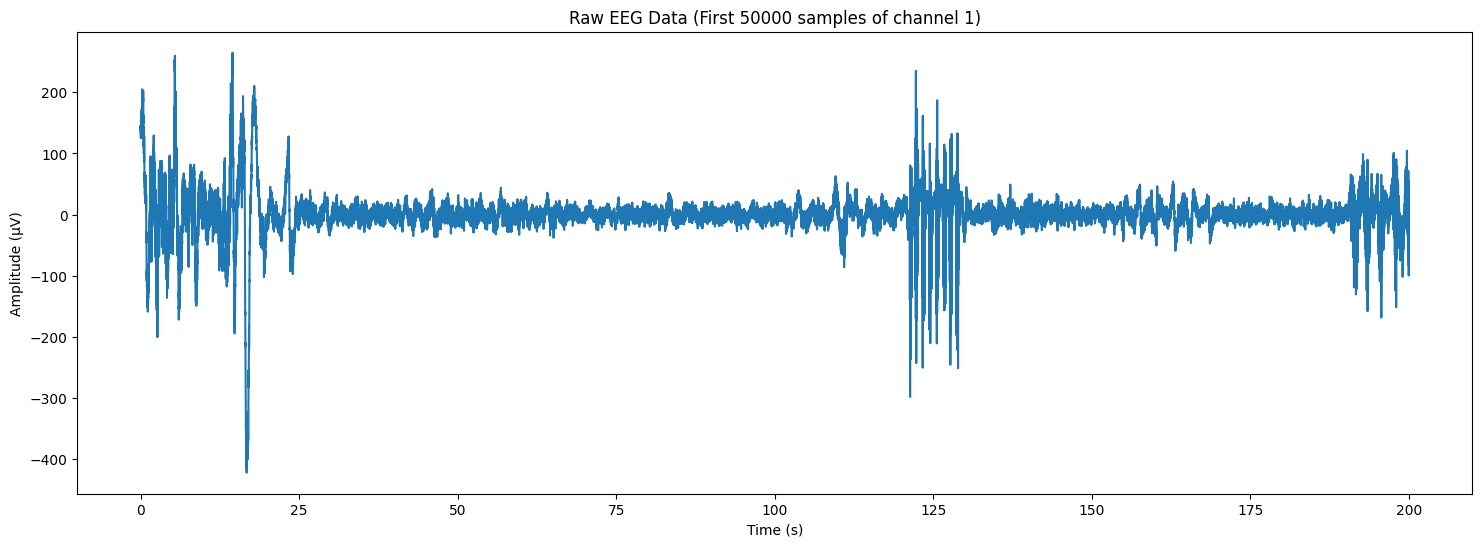

In [8]:
# Plot raw data

plt.figure(figsize=(18, 6))
plt.plot(times[:50000], raw[0, :50000].T)
plt.title("Raw EEG Data (First 50000 samples of channel 1)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.show()



## Load Epoched data

In [9]:
subject = 'S001'

X = np.load(os.path.join(DATA, subject + '_X.npy'))
y = np.load(os.path.join(DATA, subject + '_y.npy'))
X.shape, y.shape
y[:10]

array(['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S', 'S'], dtype='<U4')

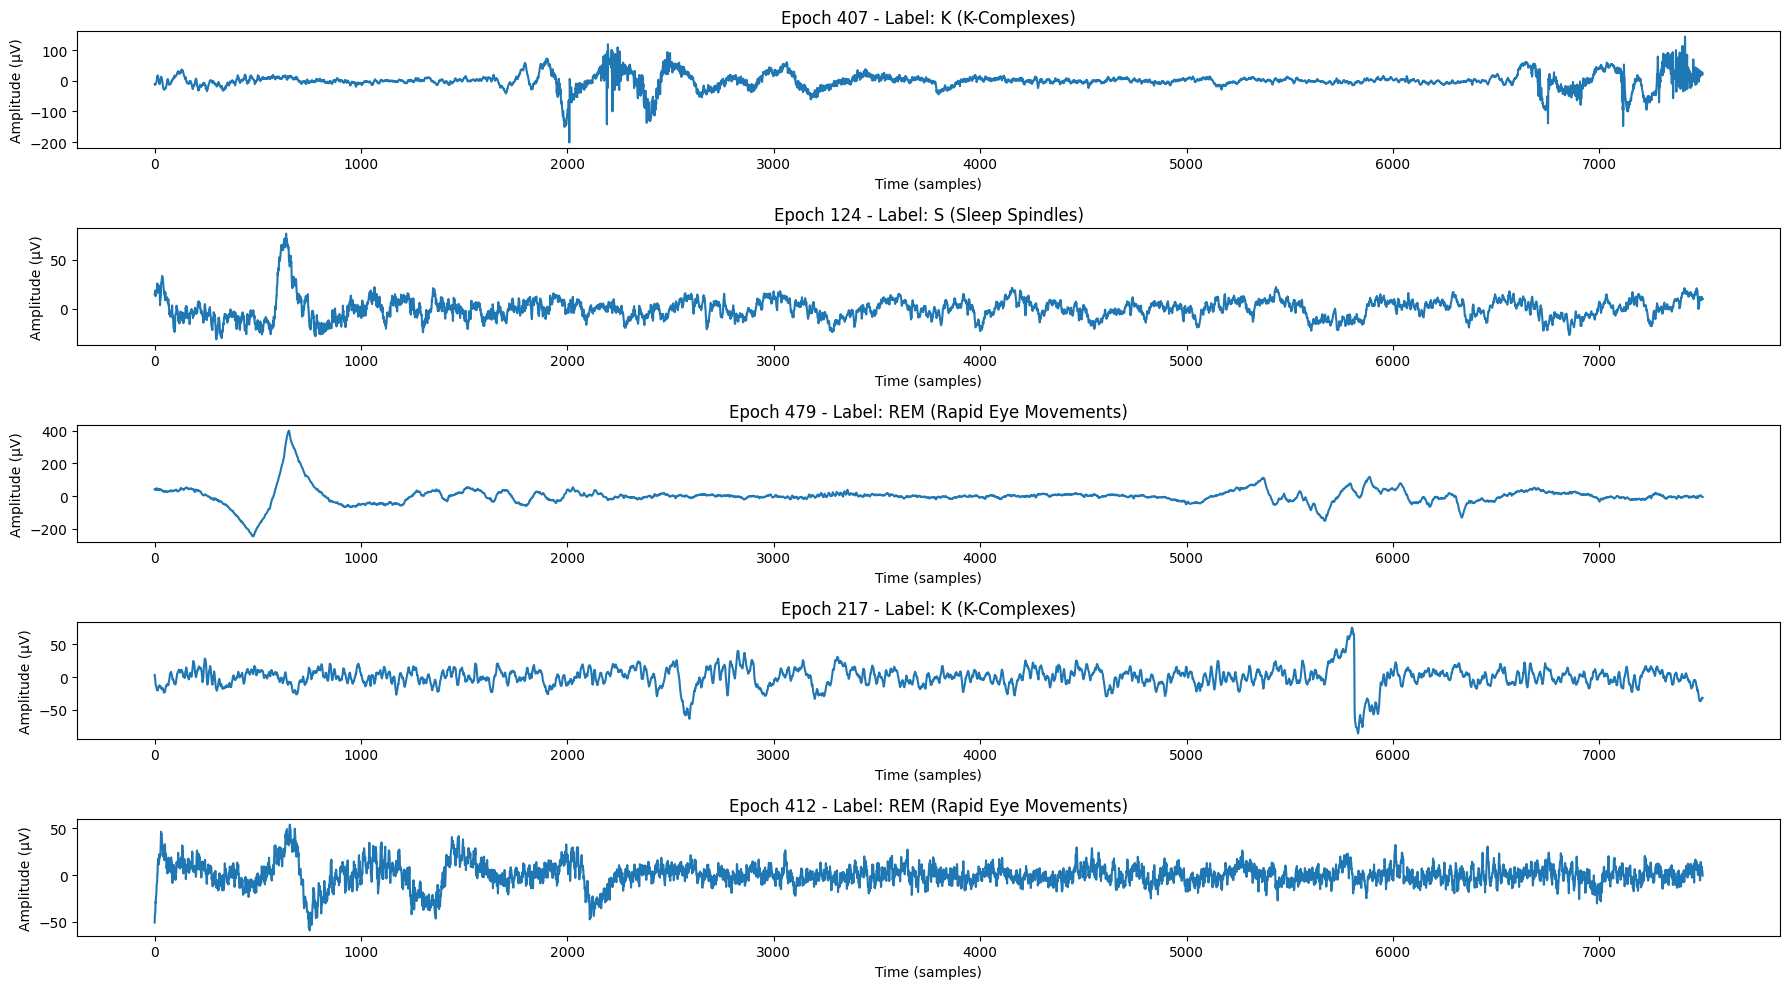

In [10]:
# PLot some epochs with their corresponding labels
n_epochs_to_plot = 5


plt.figure(figsize=(18, 10))
for i in range(n_epochs_to_plot):
    plt.subplot(n_epochs_to_plot, 1, i + 1)
    # Get a random epoch
    rnd = np.random.randint(0, X.shape[0])
    plt.plot(X[rnd].T)
    plt.title(f"Epoch {rnd} - Label: {y[rnd]} ({label_desc.get(y[rnd], 'Unknown')})")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (µV)")
plt.tight_layout()
plt.show()


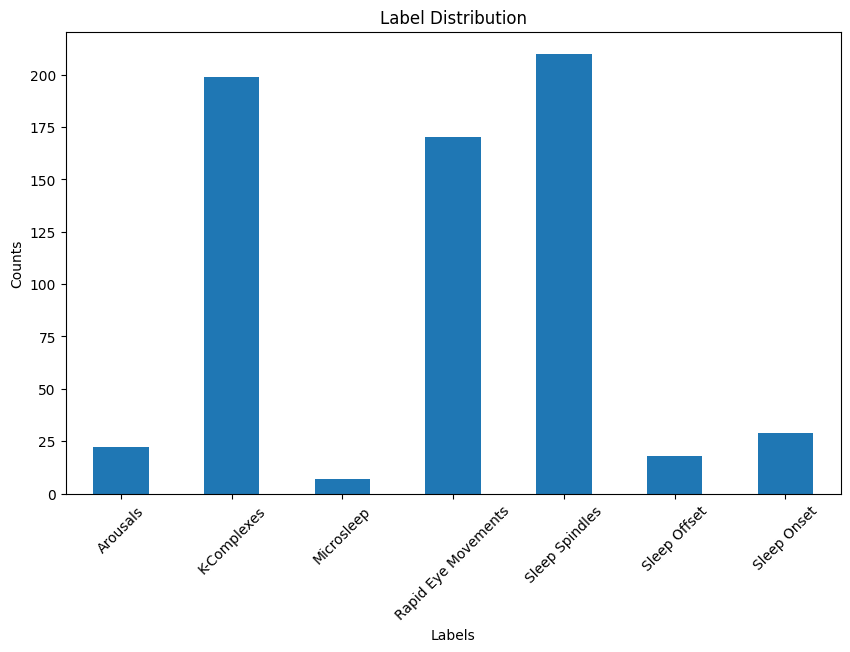

In [11]:
# Lets take a look at label distributions

label_counts = pd.Series(y).value_counts().sort_index()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.xticks(ticks=range(len(label_counts.index)), labels=[label_desc.get(lbl, lbl) for lbl in label_counts.index], rotation=45)
plt.show()

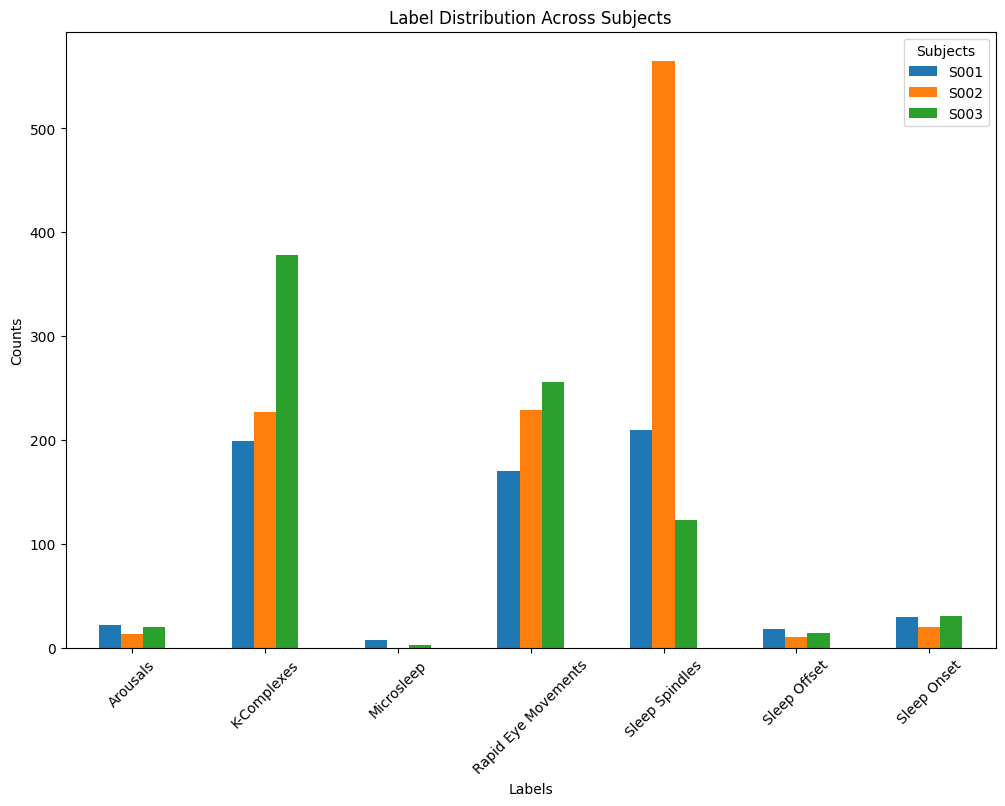

In [12]:
# Let's go through all the subjects and summarize the label distributions

subjects = ['S001', 'S002', 'S003']

all_label_counts = {}
for subject in subjects:
    y = np.load(os.path.join(DATA, subject + '_y.npy'))
    label_counts = pd.Series(y).value_counts().sort_index()
    all_label_counts[subject] = label_counts
label_counts_df = pd.DataFrame(all_label_counts).fillna(0).astype(int)
label_counts_df.index = [label_desc.get(lbl, lbl) for lbl in label_counts_df.index]
label_counts_df.plot(kind='bar', figsize=(12, 8))
plt.title("Label Distribution Across Subjects")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.legend(title='Subjects')
plt.show()



## Basic classification

In [13]:
# Let's build a basic classification model using PyTorch (Random Forest) - just to get a baseline level of performance

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data for a single subject
subject = 'S001'
X = np.load(os.path.join(DATA, subject + '_X.npy'))
y = np.load(os.path.join(DATA, subject + '_y.npy'))
X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.2, random_state=42)
# Train a Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
# Evaluate the model
accuracy = clf.score(X_test, y_test)
print(f"Random Forest Classifier Accuracy on subject {subject}: {accuracy * 100:.2f}%")
# Note: This is a very basic model and serves only as a baseline. More sophisticated models and preprocessing steps are recommended for better performance.




Random Forest Classifier Accuracy on subject S001: 45.80%


<Figure size 1800x1000 with 0 Axes>

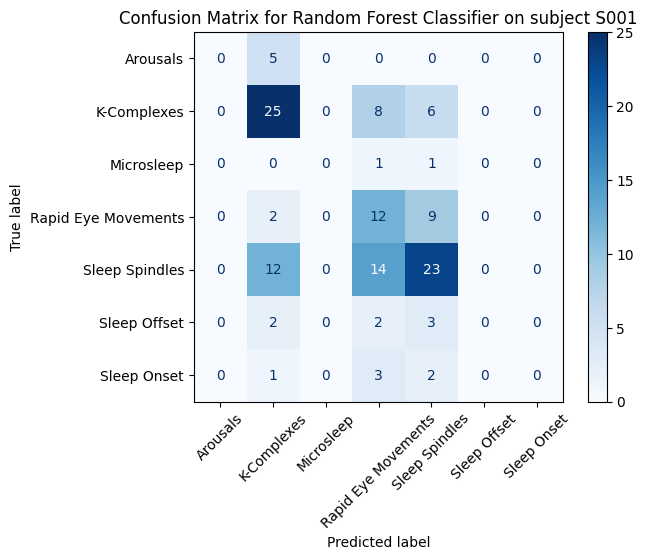

In [18]:
# Let's prepare a confusion matrix to evaluate the model performance in more detail

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
# set figure size
plt.figure(figsize=(18, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_desc.get(lbl, lbl) for lbl in np.unique(y)])
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix for Random Forest Classifier on subject {subject}")
plt.xticks(rotation=45)
plt.show()